In [1]:
from sklearn.datasets import fetch_openml

The sklearn.dataset contains three types of dataset:
* fetch*: Download and cache a dataset from the mldata.org repository.
* load*: Load a small standard dataset from sklearn.datasets.
* make*: Make a synthetic dataset.


In [2]:
mnist = fetch_openml('mnist_784', as_frame=False) # as frame = false means that the data is returned as a numpy array and not a pandas dataframe

# as_frame is used because the data is returned as a pandas dataframe and not a numpy array
# for image data, the dataframe is not very useful, so we use as_frame = False

/home/ubuntu/ml-handson/.venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target

In [4]:
X.shape # we can see that there are 70k rows aka instances and 784 features aka columns

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

To show the image, reshape the vector into 28 x 28 array and plot it using matplotlib's imshow() function.

In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary") # cmap stands for color map, binary means black and white, imshow stands for image show
    plt.axis("off") # don't show the axis

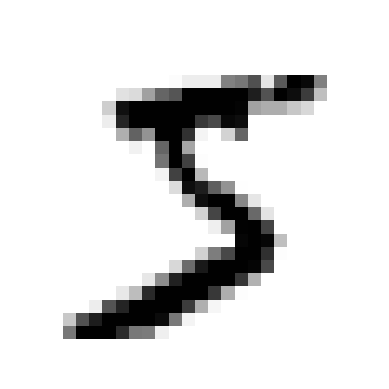

In [9]:
plot_digit(X[0])

In [10]:
y[0]

'5'

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training a binary classifier

In [13]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [14]:
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier is a linear classifier that uses SGD to train itself

In [15]:
sgd_clf = SGDClassifier(random_state=42)

In [16]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# performance measure

In [17]:
from sklearn.model_selection import cross_val_score

We split the training data into k-folds and then train the model k times each time holding out a different fold for evaluation. Each time it is trained on k-1 folds and evaluated on the held out fold. The final score is the average of the k scores obtained. This is called k-fold cross validation.

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.97192907, 0.96855413, 0.96024858])

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
dummy_clf = DummyClassifier() # dummy classifier always predict the most frequent class
dummy_clf.fit(X_train, y_train_5)

DummyClassifier()

In [24]:
print(any(dummy_clf.predict(X_train))) # any returns True if any element of the iterable is true

False


We get incredible accuracy. This is not because that we have a great model but only 10% of the data is 5s and 90% is not. This demonstrates that accuracy is not always the best measure of performance for classifiers especially for skewed datasets.

In [25]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91000161, 0.91000161, 0.90999679])

# implementing cross-validation

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
from sklearn import clone

In [28]:
skfolds = StratifiedKFold(n_splits=3) # perform stratified sampling to produce folds that contain a representative ratio of each class

In [29]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) # True/False
    print(n_correct / len(y_pred)) # 0.9502, 0.96565, 0.96495

0.9719290726951304
0.9685541329619114
0.9602485803064396


# Confusion matrix

unlike cross_val_score, cross_val_predict returns the predictions made on each test fold instead of the evaluation scores.

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
from sklearn.metrics import confusion_matrix

Each row in the confusion matrix represents an actual class. While each column represents the predicted class. The first row is class of non 5s, there are 50287 of them were correctly classified as non 5s (they are called true negatives). While the remaining 1292 were wrongly classified as 5s (false positives). The second row represents the images of 5s, 1077 were wrongly classified as non 5s (false negatives), while the remaining 4344 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [32]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[50287,   673],
       [ 1180,  3860]])

In [33]:
from sklearn.metrics import classification_report

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$


If we make a model that predicts only positive, then the precision for positive will be 100%. However this doesn't mean that the model is good.



In [34]:
print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98     50960
        True       0.85      0.77      0.81      5040

    accuracy                           0.97     56000
   macro avg       0.91      0.88      0.89     56000
weighted avg       0.97      0.97      0.97     56000



# Trade off between precision and recall

So there is this thing called `decision threshold` in binary classification that determines the boundary between two classes. `SGDClassifier` uses 0 as the default decision threshold.


In [35]:
y_score = sgd_clf.decision_function([X[0]])

In [36]:
y_score

array([-372.88017823])

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
y_scores

array([  2620.11888047, -21468.63800421,    732.41439205, ...,
        -9619.64253191, -12620.86414512, -14196.89329626])

## deciding on the vlaue of threshold

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

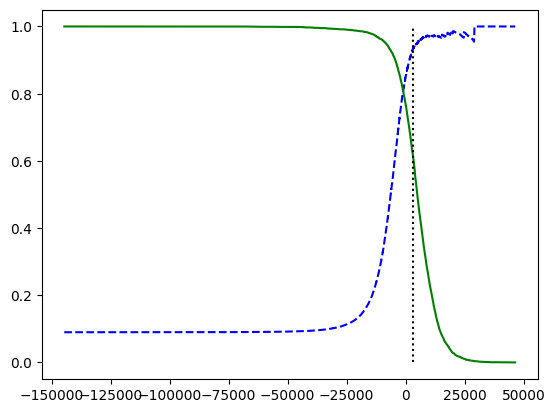

In [41]:
threshold = 3000

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")


Text(0, 0.5, 'Precision')

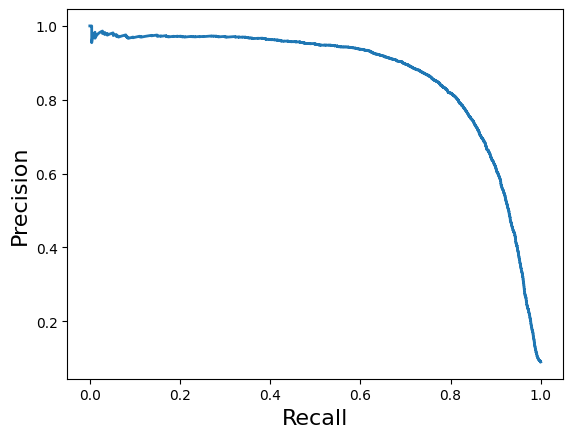

In [42]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

If we want to aim for 90% precision, then we can get the threshold using the following code:


In [43]:
idx_precision_90 = (precisions >= 0.9).argmax()
idx_precision_90

52110

In [44]:
threshold_for_90_precision = thresholds[idx_precision_90]

In [45]:
threshold_for_90_precision

1583.520690502437

In [46]:
y_train_pred_90 = (y_scores > threshold_for_90_precision)

In [47]:
from sklearn.metrics import precision_score

**approximately 90 percent precision score**

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.8999742864489586

# The ROC curve - the reciever operator characteristics 

Instead of the percision recall curve, the ROC curve plots `true positive rates` against `false positive rates` (FPR). The false positive rate is the ratio of negative instances that are incorrectly classified as positive = 1 - true negative rate (TNR). This TNR is also called the specifity.

**Hence thr ROC curve plots sensitivity (recall) and specifity.**

In [49]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

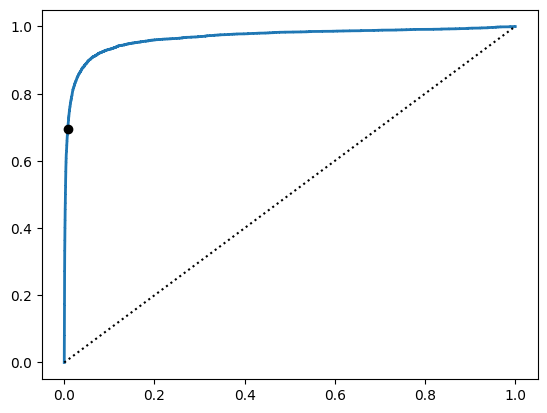

In [51]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces.

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
roc_auc_score(y_train_5, y_scores)

0.9672937302210262

You should care about about precision and recall whenever, the positive class is rare or when you care more about the false positives than the false negatives.



In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
forest_clf = RandomForestClassifier(random_state=42)

The RandomForestClassifier does not have the decision_function()

In [56]:
y_props_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

the second column contains the probability for positive class

In [57]:
y_props_forest[:2]

array([[0.24, 0.76],
       [0.99, 0.01]])

In [60]:
y_scores_forest = y_props_forest[:, 1]

In [61]:
y_scores_forest

array([0.76, 0.01, 0.02, ..., 0.  , 0.  , 0.06])

In [62]:
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

recall is the true positive rate so out of all the ones that i predicted to be positive, how many of them are actually positive
<br>
specificity is the true negative rate so out of all the ones that i predicted to be negative, how many of them are actually negative

Text(0, 0.5, 'Specificity')

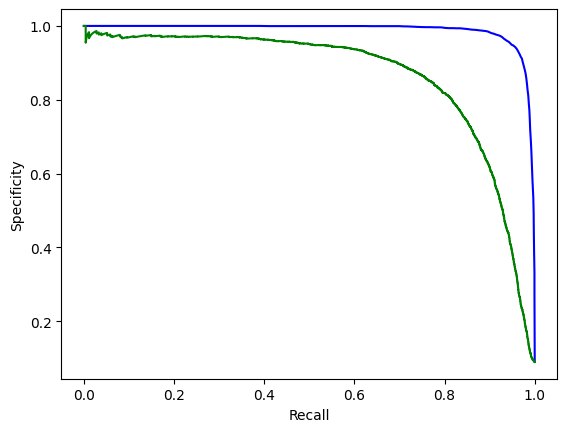

In [66]:
plt.plot(recall_forest, precision_forest, "-b", label="Random Forest")
plt.plot(recalls, precisions, "-g", label="SGD")
plt.xlabel("Recall")
plt.ylabel("Specificity")

In [76]:
y_pred_forest = y_props_forest[:, 1] >= 0.5

In [77]:
y_pred_forest

array([ True, False, False, ..., False, False, False])

In [78]:
print(classification_report(y_train_5, y_pred_forest))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     50960
        True       0.99      0.87      0.93      5040

    accuracy                           0.99     56000
   macro avg       0.99      0.93      0.96     56000
weighted avg       0.99      0.99      0.99     56000



In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982151267100247

In [80]:
from sklearn.metrics import f1_score

In [82]:
f1_score(y_train_5, y_pred_forest) # F1 score of positive class

0.9259024699176693